# Modeling

We decided to **split the noebooks** in order to be faster, since we don't need graphs anymore.

In [54]:
import pandas as pd

In [55]:
import seaborn as sb
import matplotlib.pyplot as plt


In [56]:
df = pd.read_parquet("https://github.com/maikuvit/Space-Capybaras-Final-Project/raw/main/train_clean.parquet")
df

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,GarageArea,GrLivArea,LotFrontage,MoSold,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,856,854,3,706,1,150,548,1710,65,2,...,False,False,False,False,False,False,False,False,False,False
1,1262,0,3,978,0,284,460,1262,80,5,...,False,False,False,False,False,False,False,False,False,True
2,920,866,3,486,1,434,608,1786,68,9,...,False,False,False,False,False,False,False,False,False,False
3,961,756,3,216,1,540,642,1717,60,2,...,False,False,False,False,False,False,False,False,False,False
4,1145,1053,4,655,1,490,836,2198,84,12,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,3,0,0,953,460,1647,62,8,...,False,False,False,False,False,False,False,False,False,False
1456,2073,0,3,790,1,589,500,2073,85,2,...,False,False,False,False,False,False,False,False,False,False
1457,1188,1152,4,275,0,877,252,2340,66,5,...,False,False,False,False,False,False,False,False,False,False
1458,1078,0,2,49,1,0,240,1078,68,4,...,False,False,False,False,False,False,False,False,False,False


# Modeling

In [57]:
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(df.drop(['SalePrice'], axis=1).values)
y = np.array(df['SalePrice'].values)


seed = 150
test_size = .3
val_size = .2

#Split train e test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)


### Resampling for high class label

In [58]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=seed, sampling_strategy='minority')
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)


## Creating models

In [59]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

In [60]:
# create a model for each sampling method
models = []
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('GB', GradientBoostingClassifier(random_state=seed)))
models.append(('AB', AdaBoostClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))


In [61]:
# fit each model using the training data from the oversampling 
# and evaluate its performance on the test data and save precision, accuracy, recall and f1-score

results = []
names = []

for name, model in models:
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    results.append([accuracy, precision, recall, f1score, confusion_matrix(y_test, y_pred)])
    names.append(name)



In [62]:
# create a dataframe with the results
df_results = pd.DataFrame(results, columns=['accuracy', 'precision', 'recall', 'f1-score', 'confusion_matrix'], index=names)
df_results

,accuracy,precision,recall,f1-score,confusion_matrix
RF,0.888128,0.886978,0.888128,0.886833,"[[26, 0, 12], [0, 171, 11], [6, 20, 192]]"
GB,0.869863,0.872486,0.869863,0.869498,"[[32, 0, 6], [0, 169, 13], [8, 30, 180]]"
AB,0.837900,0.842500,0.837900,0.836201,"[[23, 0, 15], [0, 149, 33], [3, 20, 195]]"
NB,0.650685,0.736593,0.650685,0.670161,"[[29, 0, 9], [0, 151, 31], [87, 26, 105]]"
KNN,0.815068,0.821505,0.815068,0.816409,"[[33, 1, 4], [0, 146, 36], [18, 22, 178]]"
DT,0.792237,0.793882,0.792237,0.792716,"[[28, 0, 10], [0, 150, 32], [15, 34, 169]]"


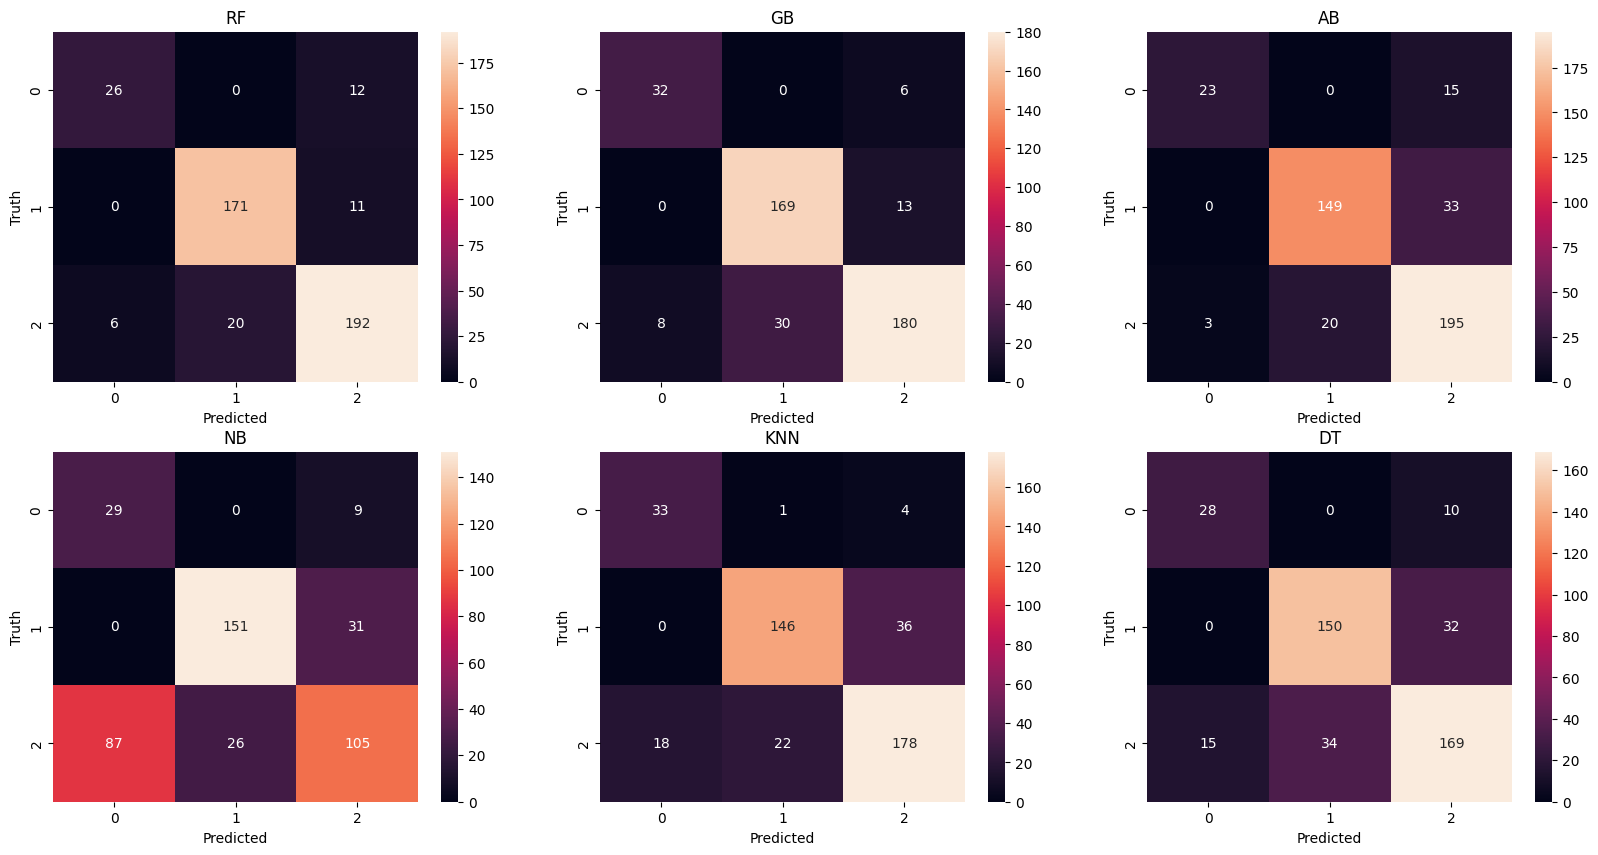

In [63]:
#create a confusion matrix for each model in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (name, model) in enumerate(models):
    row = i // 3
    col = i % 3
    axes[row, col].set_title(name)
    sb.heatmap(results[i][4], annot=True, fmt='d', cmap='rocket', ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Truth')
plt.show()


K-Fold val

In [86]:
from sklearn.model_selection import KFold, cross_val_score


kfold_results = pd.DataFrame()

for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train_smote, y_train_smote, cv=kfold, scoring='accuracy')
    kfold_results[name] = cv_results

In [88]:
kfold_results

,RF,GB,AB,NB,KNN,DT,mean
0,0.918033,0.931148,0.763934,0.760656,0.829508,0.875410,0.846448
1,0.940984,0.931148,0.806557,0.790164,0.845902,0.872131,0.864481
2,0.908197,0.914754,0.839344,0.770492,0.832787,0.832787,0.849727
3,0.895082,0.898361,0.849180,0.767213,0.845902,0.849180,0.850820
4,0.911184,0.911184,0.825658,0.726974,0.861842,0.875000,0.851974


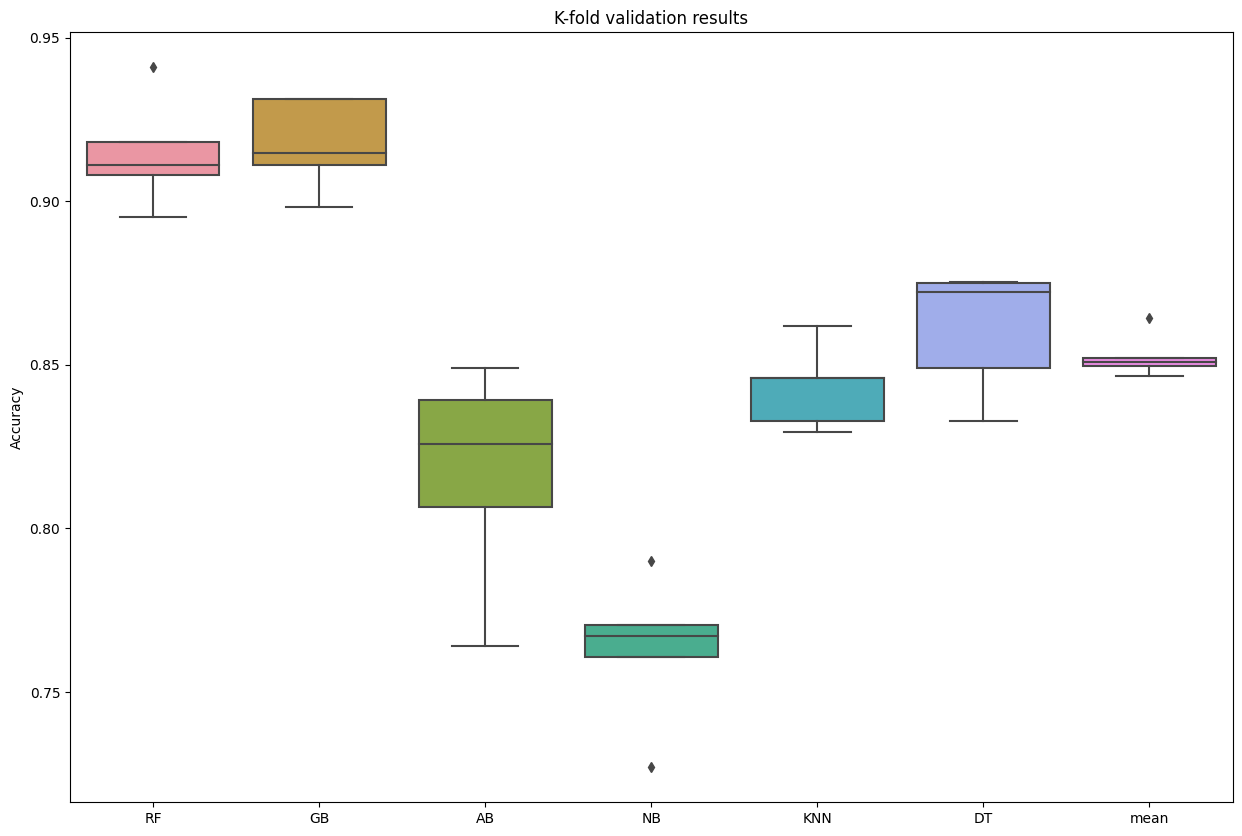

In [93]:
#plot the results of the kfold validation without boxplots

fig, ax = plt.subplots(figsize=(15, 10))
sb.boxplot(data=kfold_results, ax=ax)
ax.set_title('K-fold validation results')
ax.set_ylabel('Accuracy')
plt.show()


## Hyper Parameter Tuning

### Tuning of RandomForest

Random Forest -- Random Search CV


In [66]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_classfier_random = RandomForestClassifier(random_state=seed)

random_search = RandomizedSearchCV(estimator=rf_classfier_random, param_distributions=param_grid_rf, cv=5, scoring='accuracy')

random_search.fit(x_train_smote, y_train_smote)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred = best_model.predict(x_test)
rf_random_accuracy = accuracy_score(y_test, y_pred)


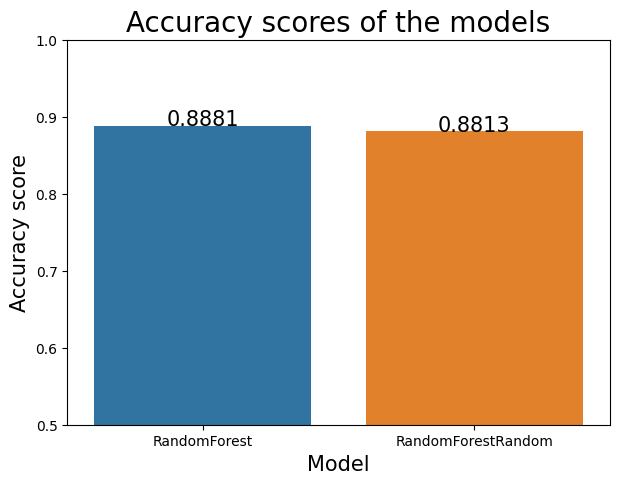

In [67]:

# Define the model names
model_names = ['RandomForest', 'RandomForestRandom']

# Define the accuracy scores
accuracy_scores = [df_results['accuracy'].loc['RF'], rf_random_accuracy]

# Create the bar plot using seaborn
plt.figure(figsize=(7, 5))
sb.barplot(x=model_names, y=accuracy_scores)

# add the the value on the top of each bar
for i in range(len(accuracy_scores)):
    plt.text(i, accuracy_scores[i], round(
        accuracy_scores[i], 4), ha='center', fontsize=15)

# Add labels and title
plt.title("Accuracy scores of the models", fontsize=20)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Accuracy score", fontsize=15)
plt.ylim(0.5, 1)

# Show the plot
plt.show()


## Features Selection

In [68]:
#for each model, find the best attributes and remove the ones that give no improvement
#and create a new list of models with the pruned models

from sklearn.feature_selection import SelectKBest, chi2
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(x_train_smote, y_train_smote)
support = fit.get_support()
feature_list = list(df.drop(['SalePrice'], axis=1).columns)

best_features = []
for i in range(len(support)):
    if support[i]:
        best_features.append(feature_list[i])

best_features

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GrLivArea',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF',
 'BsmtQual_Ex']

In [69]:
#using the new list of features, create a new dataframe with only the best features

df_best_features = df[best_features]
df_best_features['SalePrice'] = df['SalePrice']

#split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_best_features.drop(['SalePrice'], axis=1), df_best_features['SalePrice'], test_size=0.2, random_state=seed)

#apply the same sampling method as before
smote = SMOTE(random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)



C:\Users\danie\AppData\Local\Temp\ipykernel_11936\2171498776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best_features['SalePrice'] = df['SalePrice']


In [83]:
#create a list of pruned models using the same parameters as before
models_pruned = []
names_pruned = []


# fit each model using the training data from the oversampling
# and evaluate its performance on the test data and save precision, accuracy, recall and f1-score

results_pruned = []
names_pruned = []
kfold_pruned = []

models_pruned.append(('RF', RandomForestClassifier(random_state=seed)))
models_pruned.append(('GB', GradientBoostingClassifier(random_state=seed)))
models_pruned.append(('AB', AdaBoostClassifier(random_state=seed)))
models_pruned.append(('NB', GaussianNB()))
models_pruned.append(('KNN', KNeighborsClassifier()))
models_pruned.append(('DT', DecisionTreeClassifier(random_state=seed)))

for name, model in models_pruned:
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    results_pruned.append([accuracy, precision, recall, f1score, confusion_matrix(y_test, y_pred)])
    names_pruned.append(name)


In [71]:
df_results_pruned = pd.DataFrame(results_pruned, names_pruned, columns=['accuracy', 'precision', 'recall', 'f1score', 'confusion_matrix'])
df_results_pruned

,accuracy,precision,recall,f1score,confusion_matrix
RF,0.828767,0.832136,0.828767,0.829498,"[[18, 0, 4], [0, 102, 17], [9, 20, 122]]"
GB,0.825342,0.826553,0.825342,0.825669,"[[18, 0, 4], [0, 99, 20], [7, 20, 124]]"
AB,0.664384,0.692159,0.664384,0.654603,"[[14, 0, 8], [0, 104, 15], [9, 66, 76]]"
NB,0.684932,0.726413,0.684932,0.673423,"[[18, 0, 4], [0, 107, 12], [12, 64, 75]]"
KNN,0.787671,0.795209,0.787671,0.789433,"[[18, 1, 3], [1, 96, 22], [12, 23, 116]]"
DT,0.787671,0.795226,0.787671,0.789181,"[[18, 0, 4], [0, 98, 21], [13, 24, 114]]"


In [101]:


kfold_results_pruned = pd.DataFrame()

for name, model in models_pruned:
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train_smote, y_train_smote, cv=kfold, scoring='accuracy')
    kfold_results_pruned[name] = cv_results



,RF,GB,AB,NB,KNN,DT
0,0.918033,0.931148,0.763934,0.760656,0.829508,0.875410
1,0.940984,0.931148,0.806557,0.790164,0.845902,0.872131
2,0.908197,0.914754,0.839344,0.770492,0.832787,0.832787
3,0.895082,0.898361,0.849180,0.767213,0.845902,0.849180
4,0.911184,0.911184,0.825658,0.726974,0.861842,0.875000


In [102]:
kfold_results_pruned

,RF,GB,AB,NB,KNN,DT
0,0.918033,0.931148,0.763934,0.760656,0.829508,0.875410
1,0.940984,0.931148,0.806557,0.790164,0.845902,0.872131
2,0.908197,0.914754,0.839344,0.770492,0.832787,0.832787
3,0.895082,0.898361,0.849180,0.767213,0.845902,0.849180
4,0.911184,0.911184,0.825658,0.726974,0.861842,0.875000


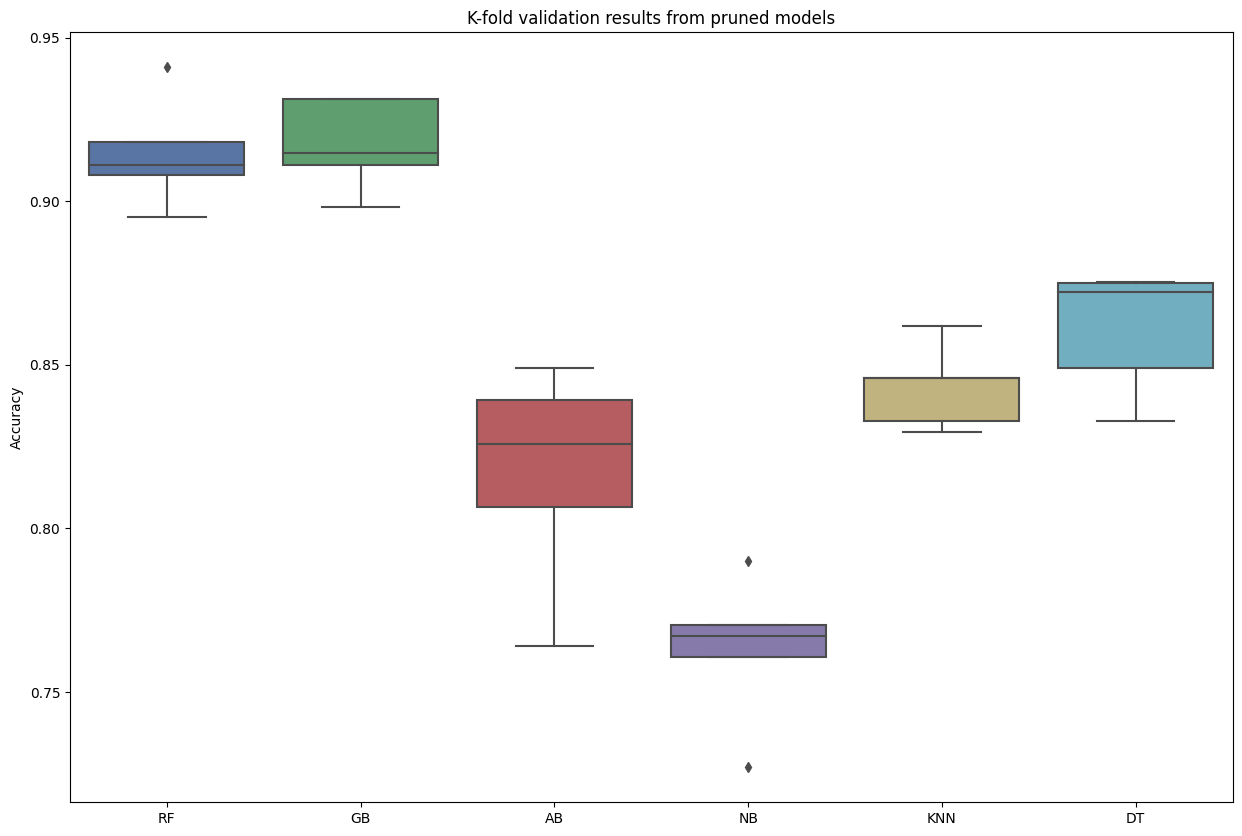

In [99]:
#compare the results of the kfold validation with boxplots

fig, ax = plt.subplots(figsize=(15, 10))
sb.boxplot(data=kfold_results_pruned, ax=ax)
ax.set_title('K-fold validation results from pruned models')
ax.set_ylabel('Accuracy')
plt.show()


### Al confusion matrixes

### Something to do

* SVC 
* Cross Validation
* Logit Regres
* MLP


# Model Evaluation

Evaluating the model without features selection

In [76]:
#split data into train and test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)


#oversample the train data using SMOTE
smote = BorderlineSMOTE(random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)


### ROC

In [77]:
from sklearn.metrics import roc_curve, auc#OVR means One class against the rest

In [78]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['SalePrice']))

In [79]:
probs = []

for name, model in models:
    model.fit(x_train_smote, y_train_smote)
    probs.append(model.predict_proba(x_test))


In [80]:

plt.style.use('seaborn-v0_8-deep')

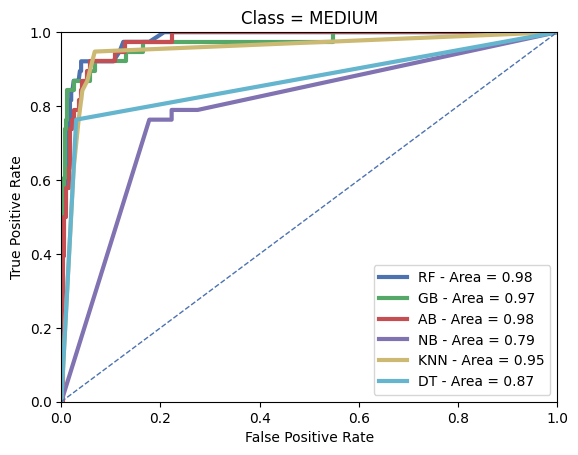

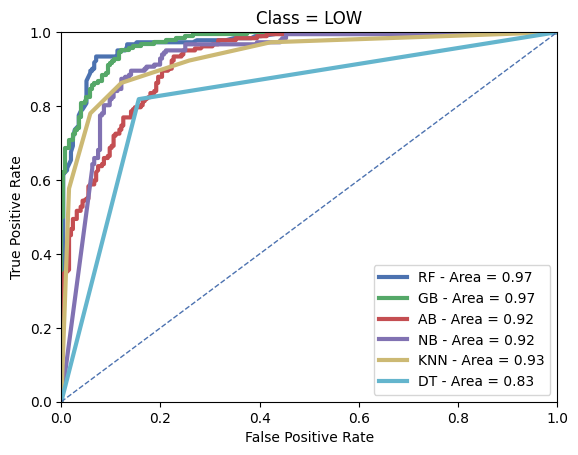

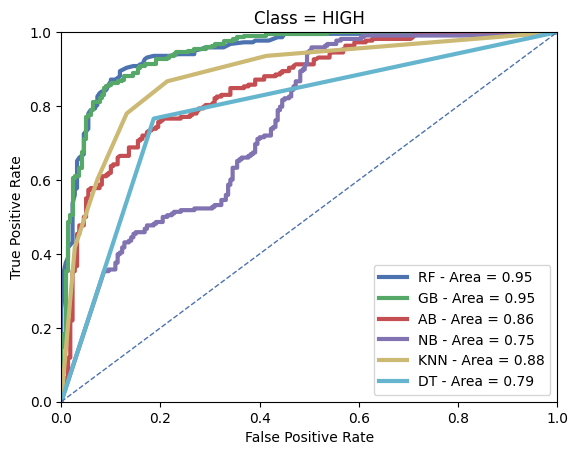

In [81]:
falsepositiverate = dict()
truepositiverate = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0
    for name, _ in models:
        falsepositiverate[i], truepositiverate[i], _ = roc_curve(one_hot_encoding[:,i], probs[m][:,i])

        roc_auc[i] = auc(falsepositiverate[i], truepositiverate[i])
        
        plt.plot(falsepositiverate[i], truepositiverate[i], lw=3, label=f"{name} - Area = {roc_auc[i]:.2f}")
        m += 1
    
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
    plt.title(f'Class = {str(np.unique(y)[2-i])}')
    plt.legend(loc='lower right')

    plt.show()
